In [1]:
import csv
import pandas as pd
import sys
#sys.path.append('./preprocess/')
#import utils
import re
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import MolToSmiles
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import rdChemReactions
from features import atom_features, bond_features
from rdkit.Chem.rdChemReactions import PreprocessReaction


In [6]:
# from patents: https://figshare.com/articles/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873
data = pd.read_csv('./data/1976_Sep2016_USPTOgrants_smiles.csv', sep='\t', nrows=50000)
#data = pd.read_csv('./data/test_human.txt', sep='\t', nrows=500000, header=None)
patents = data.PatentNumber.value_counts(sort = 0)
patents_year = data.groupby(["PatentNumber", "Year"]).size()
data

,ReactionSmiles,PatentNumber,ParagraphNum,Year,TextMinedYield,CalculatedYield
0,[Br:1][CH2:2][CH2:3][OH:4].[CH2:5]([S:7](Cl)(=...,US03930836,NaN,1976,NaN,NaN
1,[Br:1][CH2:2][CH2:3][CH2:4][OH:5].[CH3:6][S:7]...,US03930836,NaN,1976,NaN,NaN
2,[CH2:1]([Cl:4])[CH2:2][OH:3].CCOCC.[CH2:10]([S...,US03930836,NaN,1976,NaN,NaN
3,[Br:1][CH2:2][CH2:3][OH:4].[CH2:5]([S:7](Cl)(=...,US03930839,NaN,1976,NaN,NaN
4,[Br:1][CH2:2][CH2:3][CH2:4][OH:5].[CH3:6][S:7]...,US03930839,NaN,1976,NaN,NaN
...,...,...,...,...,...,...
49995,[O:1]1[CH2:6][CH2:5][C:4](=[O:7])[CH2:3][CH2:2...,US04128648,NaN,1978,39%,38.9%
49996,[CH3:1][O:2][C:3]1[C:8]([CH3:9])=[CH:7][C:6]([...,US04128648,NaN,1978,NaN,46.9%
49997,[NH:1]1[C:11]2[C:6](=[CH:7][CH:8]=[CH:9][CH:10...,US04128644,NaN,1978,NaN,NaN
49998,[OH:1][CH2:2][C:3]1[CH:15]=[C:14]2[N:5]([C:6](...,US04128644,NaN,1978,NaN,NaN


In [5]:
# droping lines from the same patent, keeping the last product - the last step
data_last = data.drop_duplicates(subset=['PatentNumber'], keep='last')
data_last

,ReactionSmiles,PatentNumber,ParagraphNum,Year,TextMinedYield,CalculatedYield
2,[CH2:1]([Cl:4])[CH2:2][OH:3].CCOCC.[CH2:10]([S...,US03930836,NaN,1976,NaN,NaN
5,[CH2:1]([Cl:4])[CH2:2][OH:3].CCOCC.[CH2:10]([S...,US03930839,NaN,1976,NaN,NaN
13,[N+:1]([C:4]1[CH:13]=[CH:12][CH:11]=[C:10]2[C:...,US03930837,NaN,1976,NaN,NaN
14,Cl.[OH:2][C@@H:3]([CH2:21][CH2:22][CH2:23][CH2...,US03930952,NaN,1976,NaN,NaN
15,CC(O[CH2:5][C:6]1[CH2:28][S:27][C@@H:9]2[C@H:1...,US03930949,NaN,1976,NaN,NaN
...,...,...,...,...,...,...
49979,[NH2:1][C@@H:2]1[C@@H:6]([CH2:7][OH:8])[O:5][C...,US04128639,NaN,1978,NaN,NaN
49987,[S:1]1[CH2:5][CH2:4][N:3]=[C:2]1[NH:6][C:7]1(O...,US04128647,NaN,1978,NaN,NaN
49988,N1C2C(=NC3C=CC=CC=3N=2)C(=O)NC=1[C:16]([OH:18]...,US04128646,NaN,1978,NaN,NaN
49996,[CH3:1][O:2][C:3]1[C:8]([CH3:9])=[CH:7][C:6]([...,US04128648,NaN,1978,NaN,46.9%


In [59]:
#data.ReactionSmiles.to_csv('./data/reactions_1000.csv', index=False)

In [123]:
data.ReactionSmiles[9]

'CC1N=CC2C(C=1)=C([N+]([O-])=O)C=CC=2.[Cl:15][C:16]1[C:25]2[C:20](=[CH:21][CH:22]=[CH:23][CH:24]=2)[CH:19]=[CH:18][N:17]=1>>[ClH:15].[Cl:15][C:16]1[C:25]2[C:20](=[CH:21][CH:22]=[CH:23][CH:24]=2)[CH:19]=[CH:18][N:17]=1 |f:2.3|'

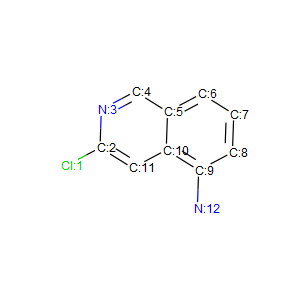

In [124]:
mol = AllChem.MolFromSmarts('[Cl:1][C:2]1[N:3]=[CH:4][C:5]2[C:10]([CH:11]=1)=[C:9]([NH2:12])[CH:8]=[CH:7][CH:6]=2')
Draw.MolToImage(mol)

In [12]:
reaction_count = []
for item in data.ReactionSmiles:
    reaction_count.append(item.count('>')/2)

sum(reaction_count)


500000.0

In [32]:
rxn_1 = AllChem.ReactionFromSmarts(re.sub(r'\|f:.+\|', '', data.ReactionSmiles[6]))
rxn_2 = AllChem.ReactionFromSmarts(re.sub(r'\|f:.+\|', '', data.ReactionSmiles[7]))
rxn_3 = AllChem.ReactionFromSmarts(re.sub(r'\|f:.+\|', '', data.ReactionSmiles[8]))
rxn_4 = AllChem.ReactionFromSmarts(re.sub(r'\|f:.+\|', '', data.ReactionSmiles[9]))
rxn_5 = AllChem.ReactionFromSmarts(re.sub(r'\|f:.+\|', '', data.ReactionSmiles[10]))
rxn_6 = AllChem.ReactionFromSmarts(re.sub(r'\|f:.+\|', '', data.ReactionSmiles[11]))

rxn_1.Initialize()
nWarn,nError,nReacts,nProds,reactantLabels = PreprocessReaction(rxn_1)
PreprocessReaction(rxn_1)
ras=rxn_1.GetReactingAtoms()
ras, nReacts

(((8, 9, 10), (0,), (0,), (0,)), 4)

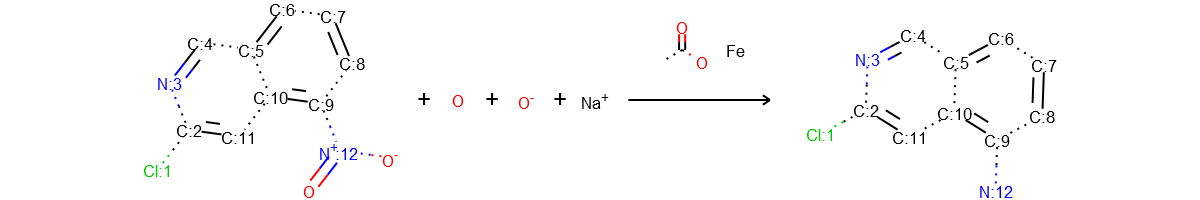

In [33]:
Draw.ReactionToImage(rxn_1)

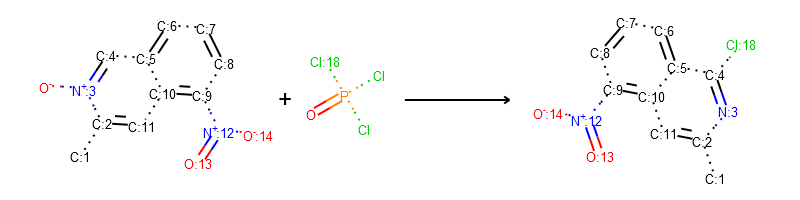

In [34]:
Draw.ReactionToImage(rxn_2)

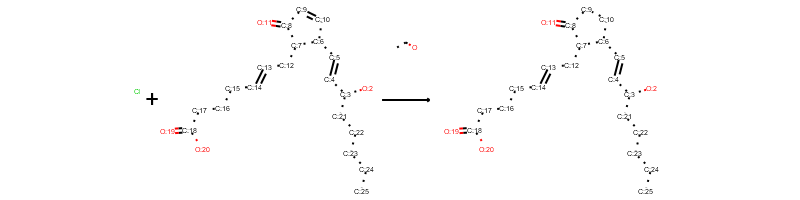

In [76]:
Draw.ReactionToImage(rxn_3)

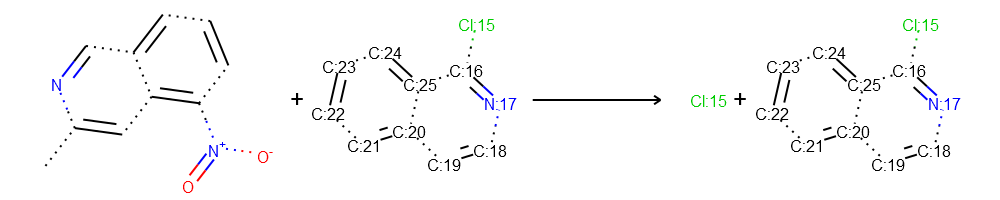

In [125]:
Draw.ReactionToImage(rxn_4)

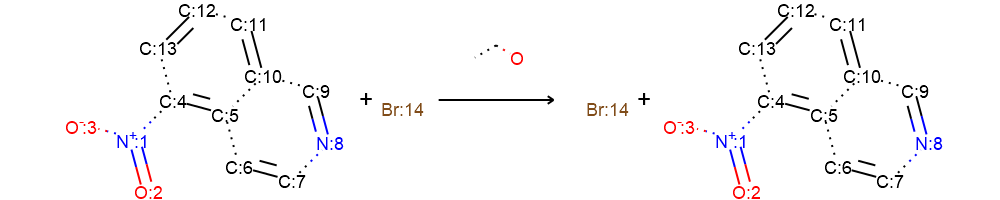

In [128]:
Draw.ReactionToImage(rxn_6)

In [27]:
mol = AllChem.MolFromSmarts('[C:14]1(=O)[CH2:21]CCCCC[CH2:15]1.C1(C(C)=O)CC1')

In [28]:
mol =  AllChem.MolFromSmarts('[C:1]([NH:5][NH:6][C:7]([C:12]#[N:13])([CH:9]1[CH2:11][CH2:10]1)[CH3:8])([CH3:4])([CH3:3])[CH3:2].[C:14]1(=O)[CH2:21]CCCCC[CH2:15]1.C1(C(C)=O)CC1')

In [72]:
# I want to extract reactants and products from the reaction
# iterator
prods = rxn_1.GetProducts()
reakts = rxn_1.GetReactants()

In [73]:
x = [m for m in reakts]

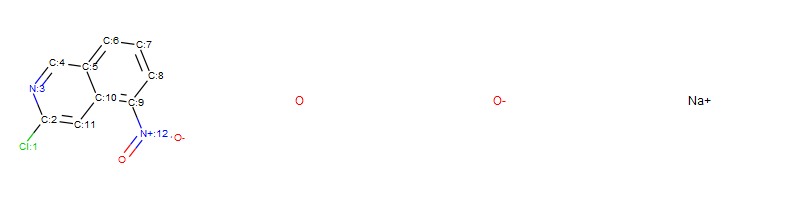

In [74]:
Draw.MolsToImage(x)

In [188]:
test = MolToSmiles(x[0])
m = AllChem.MolFromSmiles(test, sanitize=True)

In [170]:
fp = AllChem.GetMorganFingerprint(m,2)

In [171]:
fp = AllChem.GetMorganFingerprintAsBitVect(m,2)
fp = fp.ToBitString()

In [189]:
fp_inchi = AllChem.inchi.MolToInchi(m)

In [190]:
fp = [int(s) for s in fp]

In [174]:
fp_inchi

'InChI=1S/C11H6N4O/c12-6-7-5-10-8-3-1-2-4-9(8)13-11(16)15(10)14-7/h1-5H,(H,13,16)'

In [175]:
from rdkit.Chem import MACCSkeys
fp_macc = MACCSkeys.GenMACCSKeys(m).ToBitString()

In [176]:
fp_macc

'00000000000000000000000000000000000001000100000000001000000000000100000000000101100100000000001110100100011000100100010011101101000000000100001101001001001010000111110'

In [84]:
len(fp)

2048

In [191]:
a = m.GetAtoms()[0]

{}

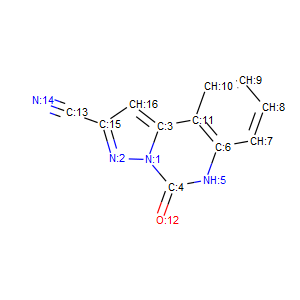

In [192]:
Draw.MolToImage(m)

In [ ]:
fp = fp.ToBitString()

In [77]:

def bitstring_to_bytes(s):
    return int(s, 2).to_bytes(len(s) // 8, byteorder='big')
a = bitstring_to_bytes(fp)
a

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 \x00\x00 \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00P\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01 \x00\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00@\x00 \x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x10\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x01\x80\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x02\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x0

# predict number of reactants

In [85]:
# x, y data
reactions = []
products = []
y_morgans = []
x_data = []
counter = 0
for i in range(len(data)):
    if i % 10000 == 0:
        print('zpracovano: ', i)
    reaction = AllChem.ReactionFromSmarts(re.sub(r'\|.+\|', '', data.ReactionSmiles[i]))
    reactions.append(reaction)    
    product = reaction.GetProducts()
    reaction.Initialize()
    nWarn,nError,nReacts,nProds,reactantLabels = PreprocessReaction(reaction)
    x = [m for m in product]
    m = AllChem.MolToSmiles(x[-1], 2)
    m = AllChem.MolFromSmiles(m, sanitize=True)
    try:
        fp = AllChem.GetMorganFingerprintAsBitVect(m,2)
        fp = [int(s) for s in fp]
        x_data.append(nProds)
        products.append(product)
        y_morgans.append(fp)
    except:
        counter +=1
        
print(counter)   

zpracovano:  0
zpracovano:  10000
zpracovano:  20000
zpracovano:  30000
zpracovano:  40000
5


In [ ]:
# ff network

In [50]:
# packages
import matplotlib
matplotlib.use("Agg")
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
#import cv2
import os

In [86]:
(trainX, testX, trainY, testY) = train_test_split(y_morgans, x_data, test_size=0.25, random_state=42) # mam to obracene

In [87]:
label_encoder = LabelEncoder()
trainY = label_encoder.fit_transform(trainY)
testY = label_encoder.fit_transform(testY)

In [88]:
# takhle to jde take
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [89]:
trainY[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [90]:
# network

In [98]:
len(fp)

2048

In [106]:
model = Sequential()
model.add(Dense(int(len(fp)/2), input_shape=(len(fp),), activation="sigmoid"))
model.add(Dense(int(len(fp)/2), activation="sigmoid"))
model.add(Dense(len(lb.classes_), activation="softmax"))

In [109]:
INIT_LR = 0.01
EPOCHS = 20
opt = SGD(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [110]:
H = model.fit(np.array(trainX), np.array(trainY), validation_data=(np.array(testX), np.array(testY)), epochs=EPOCHS, batch_size=32)

Train on 37496 samples, validate on 12499 samples
Epoch 1/20
37496/37496 [==============================] - 25s 668us/step - loss: 0.5137 - acc: 0.8633 - val_loss: 0.4995 - val_acc: 0.8657
Epoch 2/20
37496/37496 [==============================] - 25s 657us/step - loss: 0.5114 - acc: 0.8633 - val_loss: 0.5109 - val_acc: 0.8657
Epoch 3/20
37496/37496 [==============================] - 25s 654us/step - loss: 0.5108 - acc: 0.8633 - val_loss: 0.5113 - val_acc: 0.8657
Epoch 4/20
37496/37496 [==============================] - 25s 656us/step - loss: 0.5076 - acc: 0.8633 - val_loss: 0.4950 - val_acc: 0.8657
Epoch 5/20
37496/37496 [==============================] - 25s 655us/step - loss: 0.5053 - acc: 0.8633 - val_loss: 0.5055 - val_acc: 0.8657
Epoch 6/20
37496/37496 [==============================] - 25s 658us/step - loss: 0.5026 - acc: 0.8633 - val_loss: 0.4884 - val_acc: 0.8657
Epoch 7/20
37496/37496 [==============================] - 25s 658us/step - loss: 0.4994 - acc: 0.8633 - val_loss: 0.

In [123]:
preds = model.predict(np.array(testX))

In [128]:
preds[1]

array([7.1077627e-01, 2.4207644e-01, 2.8742108e-02, 1.1436752e-02,
       3.2065562e-03, 9.5391559e-04, 1.3936171e-03, 2.9877486e-04,
       2.1526474e-04, 2.6102152e-04, 2.6654097e-04, 9.5221454e-05,
       5.6075318e-05, 5.6257973e-05, 5.4563767e-05, 5.5535405e-05,
       5.5016109e-05], dtype=float32)

In [134]:
np.rint(preds[1])

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [131]:
Y = testY[1]
Y

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# MACCS keys

In [162]:
# x, y data
reactions = []
products = []
y_morgans = []
x_data = []
counter = 0
for i in range(len(data)):
    if i % 10000 == 0:
        print('zpracovano: ', i)
    reaction = AllChem.ReactionFromSmarts(re.sub(r'\|.+\|', '', data.ReactionSmiles[i]))
    reactions.append(reaction)    
    product = reaction.GetProducts()
    reaction.Initialize()
    nWarn,nError,nReacts,nProds,reactantLabels = PreprocessReaction(reaction)
    x = [m for m in product]
    m = AllChem.MolToSmiles(x[-1], 2)
    m = AllChem.MolFromSmiles(m, sanitize=True)
    try:
        fp = MACCSkeys.GenMACCSKeys(m).ToBitString()
        fp = [int(s) for s in fp]
        x_data.append(nProds)
        products.append(product)
        y_morgans.append(fp)
    except:
        counter +=1
        
print(counter)   

zpracovano:  0
zpracovano:  10000
zpracovano:  20000
zpracovano:  30000
zpracovano:  40000
5


In [163]:
np.array(trainX)[0]

'00000000000000000000000000000000000000000000000000001000000000100000010000000010000000000011101101100000100001110110011111001011000010000100001111010011111111111111110'

In [164]:
(trainX, testX, trainY, testY) = train_test_split(y_morgans, x_data, test_size=0.25, random_state=42) # mam to obracene
# takhle to jde take
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

model2 = Sequential()
model2.add(Dense(len(fp), input_shape=(len(fp),), activation="sigmoid"))
model2.add(Dense(int(len(fp)/2), activation="sigmoid"))
model2.add(Dense(len(lb.classes_), activation="softmax"))

In [165]:
INIT_LR = 0.01
EPOCHS = 3
opt = SGD(lr=INIT_LR)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [167]:
H2 = model2.fit(np.array(trainX), np.array(trainY), validation_data=(np.array(testX), np.array(testY)), epochs=EPOCHS, batch_size=32)

Train on 37496 samples, validate on 12499 samples
Epoch 1/3
37496/37496 [==============================] - 4s 104us/step - loss: 0.5491 - acc: 0.8609 - val_loss: 0.5033 - val_acc: 0.8657
Epoch 2/3
37496/37496 [==============================] - 1s 38us/step - loss: 0.5062 - acc: 0.8633 - val_loss: 0.4971 - val_acc: 0.8657
Epoch 3/3
37496/37496 [==============================] - 1s 38us/step - loss: 0.5009 - acc: 0.8633 - val_loss: 0.4919 - val_acc: 0.8657


In [196]:
#Smiles sequence to vector

In [365]:
new_Data = (data.ReactionSmiles.str.replace(r'\d*:\d*', ''))

In [366]:
new_Data

0        [Br][CH][CH][OH].[CH]([S](Cl)(=[O])=[O])[CH].C...
1        [Br][CH][CH][CH][OH].[CH][S](Cl)(=[O])=[O].CCO...
2        [CH]([Cl])[CH][OH].CCOCC.[CH]([S](Cl)(=[O])=[O...
3        [Br][CH][CH][OH].[CH]([S](Cl)(=[O])=[O])[CH].C...
4        [Br][CH][CH][CH][OH].[CH][S](Cl)(=[O])=[O].CCO...
                               ...                        
49995    [O]1[CH][CH][C](=[O])[CH][CH]1.[CH][C]1[CH]=[C...
49996    [CH][O][C]1[C]([CH])=[CH][C]([CH]=[C]2[C](=O)[...
49997    [NH]1[C]2[C](=[CH][CH]=[CH][CH]=2)[C](=O)[C]1=...
49998    [OH][CH][C]1[CH]=[C]2[N]([C](=[O])[NH][C]3[CH]...
49999    [N+](=[C]1[C]2[C](=[CH][CH]=[CH][CH]=2)[NH][C]...
Name: ReactionSmiles, Length: 50000, dtype: object

In [367]:
reactions_all = new_Data.str.split(">>", n = 1, expand = True)
reactions_all = reactions_all.mask(reactions_all.eq('None')).dropna()
reactions_all

,0,1
7,[CH][C]1[N+]([O-])=[CH][C]2[C]([CH]=1)=[C]([N+...,[Cl][C]1[C]2[C](=[C]([N+]([O-])=[O])[CH]=[CH][...
8,[CH][C]1[N]=[CH][C]2[C]([CH]=1)=[C]([N+]([O-])...,[ClH].[CH][C]1[N]=[CH][C]2[C]([CH]=1)=[C]([N+]...
9,CC1N=CC2C(C=1)=C([N+]([O-])=O)C=CC=2.[Cl][C]1[...,[ClH].[Cl][C]1[C]2[C](=[CH][CH]=[CH][CH]=2)[CH...
10,CC1N=CC2C(C=1)=C([N+]([O-])=O)C=CC=2.[Cl][C]1[...,[IH].[Cl][C]1[CH]=[CH][C]([N+]([O-])=[O])=[C]2...
12,[N+](C1C=CC=C2C=1C=CN=C2)([O-])=O.[CH][C]1[C]2...,[Cl][C]1[C]([O-])=[C]([Cl])[C]([Cl])=[C]([Cl])...
...,...,...
49969,[C]([C]1([OH])[CH][CH][CH][CH][CH]1)#[CH].C([O...,[CH][S]([CH]([CH][C]#[C][C]1([OH])[CH][CH][CH]...
49970,[CH][S]([CH]([CH][C]#[C][C@@H]([OH])[CH][CH][C...,[CH][S]([CH]([CH][CH][CH][C]1([OH])[CH][CH][CH...
49971,[CH][S]([CH]([CH][CH][CH][CH]([O]C(=O)C)[CH][C...,[CH][S]([CH]([CH][CH][CH][CH]([OH])[CH][CH][CH...
49988,N1C2C(=NC3C=CC=CC=3N=2)C(=O)NC=1[C]([OH])=[O]....,[CH]([O][C]([C]1[NH][C](=[O])[C]2=[N][C]3[CH]=...


In [398]:
charset = set("".join(list(products))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(react) for react in reactions_all[1]]) + 5
print(str(charset))
print(len(charset), embed)

TypeError: sequence item 0: expected str instance, list found

In [348]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]


In [292]:
reactants_mat = vectorize(reactions_all[0].values)  
products_mat = vectorize(reactions_all[1].values)

In [290]:
reactants_vec[0][0].shape, reactions_all[0].shape

((1377, 59), (13021,))

In [242]:
back = "".join([int_to_char[idx] for idx in np.argmax(reactants_vec[0][0], axis=1)])
back

'![CH3:1][C:2]1[N+:3]([O-])=[CH:4][C:5]2[C:10]([CH:11]=1)=[C:9]([N+:12]([O-:14])=[O:13])[CH:8]=[CH:7][CH:6]=2.P(Cl)(Cl)([Cl:18])=OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

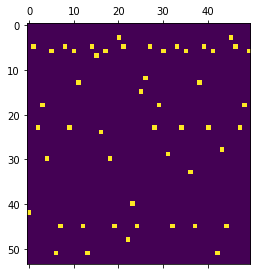

In [232]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.matshow(reactants_vec[0][0][0:50].T)

In [281]:
reactants_vec[0].shape

(13021, 1377, 59)

In [293]:
reactants_vec = reactants_mat[0].reshape((len(reactants_mat[0]), np.prod(reactants_mat[0].shape[1:])))
products_vec = products_mat[0].reshape((len(products_mat[0]), np.prod(products_mat[0].shape[1:])))
print(reactants_vec.shape)

(13021, 81243)


In [294]:
(trainX, testX, trainY, testY) = train_test_split(reactants_vec, products_vec, test_size=0.25, random_state=42)
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

In [295]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 59  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(81243,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(81243, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [296]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [297]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [298]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [299]:
autoencoder.fit(trainX, trainY,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(testX, testY))

Train on 9765 samples, validate on 3256 samples
Epoch 1/5
9765/9765 [==============================] - 59s 6ms/step - loss: 0.6928 - val_loss: 0.6918
Epoch 2/5
9765/9765 [==============================] - 47s 5ms/step - loss: 0.6754 - val_loss: 0.6128
Epoch 3/5
9765/9765 [==============================] - 48s 5ms/step - loss: 0.3667 - val_loss: 0.1212
Epoch 4/5
9765/9765 [==============================] - 48s 5ms/step - loss: 0.0654 - val_loss: 0.0365
Epoch 5/5
9765/9765 [==============================] - 48s 5ms/step - loss: 0.0282 - val_loss: 0.0225


In [301]:
encoded_imgs = encoder.predict(testX)
decoded_imgs = decoder.predict(encoded_imgs)

In [314]:
orig = testY[0].reshape(1377, 59)

In [319]:
y = np.rint(decoded_imgs[0])
y = decoded_imgs[0]
y = y.reshape(1377, 59)

In [320]:
back_y = "".join([int_to_char[idx] for idx in np.argmax(y, axis=1)])
back_orig = "".join([int_to_char[idx] for idx in np.argmax(orig, axis=1)])

In [321]:
back_y, back_orig

('![CH::1][[::]][[[::]][[[:::]][[::]:[]][[]:::][[]::]]][]:::]][][[::]]][[::]]][[:::]]][[:]:EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

In [323]:
reactions_all[0][7]

'[CH3:1][C:2]1[N+:3]([O-])=[CH:4][C:5]2[C:10]([CH:11]=1)=[C:9]([N+:12]([O-:14])=[O:13])[CH:8]=[CH:7][CH:6]=2.P(Cl)(Cl)([Cl:18])=O'

In [434]:
x = '[CH3:1][C:2]1[N+:3]([O-])=[CH:4][C:5]2[C:10]([CH:11]=1)=[C:9]([N+:12]([O-:14])=[O:13])[CH:8]=[CH:7][CH:6]=2'
a = re.sub(':\d+', '', x)

print(a)
m1 = AllChem.MolFromSmiles(a, sanitize=True)
print(m1)

[CH3][C]1[N+]([O-])=[CH][C]2[C]([CH]=1)=[C]([N+]([O-])=[O])[CH]=[CH][CH]=2


In [435]:
m2 = AllChem.MolFromSmiles('[C][C]1[N+]([O-])=[CH][C]2[C]([CH]=1)=[C]([N+]([O-])=[O])[CH]=[CH][CH]=2')
test = AllChem.MolToSmiles(m1)
m3 = AllChem.MolFromSmiles(test)
test

'Cc1cc2c([N+](=O)[O-])cccc2c[n+]1[O-]'

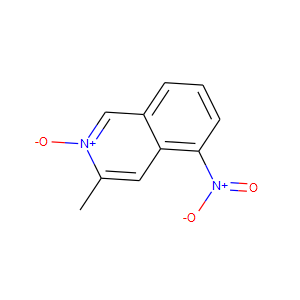

In [436]:
Draw.MolToImage(m3)

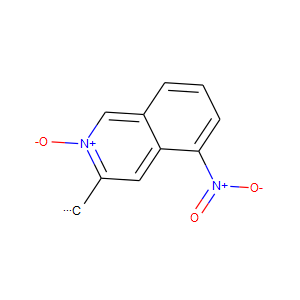

In [384]:
Draw.MolToImage(m2)

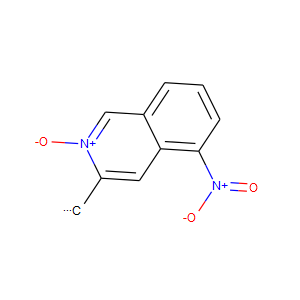

In [388]:
Draw.MolToImage(m3)

zpracovano:  0
zpracovano:  1
zpracovano:  2
zpracovano:  3
zpracovano:  4
[]
[]
[]
[]
[]
[]


In [419]:
m = AllChem.MolFromSmiles('[CH3:1][c:2]1[n:3][c:4]([Cl:18])[c:5]2[cH:6][cH:7][cH:8][c:9]([N+:12](=[O:13])[O-:14])[c:10]2[cH:11]1')